# <center> Data Analysis for Strategic Route Selection
 </center>
<center> Oct 2023, Mingming Zhang </center>

# Table of contents
1. [Problem Statement](#statement)


2. [Introduction of Data Management](#introduction)


3. [Defined Functions](#functions)


4. [Data Preprocessing](#preprocessing)
    - [Flights](#table1)
    - [Airport_Codes](#table2)
    - [Tickets](#table3)


5. [Problem Solving](#problems)
    - [Problem 1: Busiest Routes](#problem1)
    - [Problem 2: Most Profitable Routes](#problem2)
    - [Problem 3: Recommended Routes](#problem3)
    - [Problem 4: Breakeven Analysis](#problem4)
    - [Problem 5: Key Performance Indicators](#problem5)
   

6. [Further Steps](#nextsteps) 

# Problem Statement <a name="statement"></a>

You are consulting for an airline company looking to enter the United States domestic market
which has identified medium and large airports as their desired operating locations. The
company believes that it has a competitive advantage in maintaining punctuality, so it plans on
making this a big part of its brand image with a motto, “On time, for you.” To kick start
operations, the company has decided to start with 5 round trip routes. An example of a round
trip route is the combination of JFK to ORD and ORD to JFK. The opposite order of the
route, ORD to JFK and JFK to ORD, would be considered the same round trip.
You have been tasked with analyzing 1Q2019 data to identify:
1. The 10 busiest round trip routes in terms of number of round trip flights in the quarter.
Exclude canceled flights when performing the calculation.
2. The 10 most profitable round trip routes (without considering the upfront airplane cost) in
the quarter. Along with the profit, show total revenue, total cost, summary values of other
key components and total round trip flights in the quarter for the top 10 most profitable
routes. Exclude canceled flights from these calculations.
3. The 5 round trip routes that you recommend to invest in based on any factors that you
choose.
4. The number of round trip flights it will take to breakeven on the upfront airplane cost for
each of the 5 round trip routes that you recommend. Print key summary components for
these routes.
5. Key Performance Indicators (KPI’s) that you recommend tracking in the future to
measure the success of the round trip routes that you recommend.

# Introduction of Data Management <a name="introduction"></a>

We will first perform a quality check on three tables separately and then proceed with a merged analysis. During this process, we will remove duplicate values, handle anomalies and outliers, impute missing values and make changes to columns. Since each table has its unique composition, the order of our handling is different. Next, we will briefly summarize the individual handling of the three tables.

#### Flights:
This table contains data about available routes from origin to destination. For this table, we first remove duplicate values, and then we will divide the data to be processed into categorical and numerical 
variables. For categorical variables, we need ORIGIN, DESTINATION, and OP_CARRIER. ORIGIN and DESTINATION are the airport's IATA code, which can help us merge with the other two tables. OP_CARRIER can help us analyze different airline companies. We will first check missing value and then write a regular expression based on the pattern of these three columns, and after finding that they have no anomalies,  we will begin processing numerical variables. For numerical data, we will focus on DISTANCE and OCCUPANCY_RATE, since they can help us calculate the revenue. We also need to check DEP_DELAY and ARR_DELAY as they are relevant to punctuality and delay cost. We first checked the anomalies of DISTANCE (some non-numeric values, some negative values, and some inconsistent numbers) and deal with them. In this process, we also filled the missing values of DISTANCE by same (ORIGIN, DESTINATION) combination. Then, it is OCCUPANCY_RATE, there were no anomalies found in OCCUPANCY_RATE, and used the average OCCUPANCY_RATE of the same ORIGIN, DESTINATION and OP_CARRIER to fill the missing values.
Then, We checked the anomalies and missing values of ARR_DELAY and DEP_DELAY, found no anomalies, but some missing values in ARR_DELAY needed to be handled. Through correlation analysis, we found that their correlation coefficients were very high, so we used linear regression to complete the missing DEP_DELAY. In the end, we checked the outliers of these numerical variables and found only DISTANCE had an outlier, and it doesn't need to be handled.

#### Airport_Codes:
We use this table to identify whether an airport is considered medium or large-sized in the US. For this table, we only need three columns: TYPE, ISO_COUNTRY, and IATA_CODE. All three are categorical variables. The first two are used to identify whether an airport is considered medium or large-sized in the US, and IATA_CODE is used to connect other tables. There were no duplicate values in this table, the data in the TYPE column was entirely correct, but there were some missing values in ISO_COUNTRY. After checking, these were not from the US but some African countries, so we deleted those columns. We found missing values in IATA_CODE; we needed to check to ensure that important airport routes were not ignored. By the frequency of their region in the flights table, we filled in the important airport's IATA_CODE and deleted the codes of useless airports. After dealing with the null values, we performed anomaly detection and found no anomalies in this IATA_CODE column.

#### Tickets:
This table contains ticket prices data. After removing duplicate values, we divided the data to be processed into categorical and numerical variables. For categorical variables, we need ORIGIN, DESTINATION, REPORTING_CARRIER, and ROUNDTRIP. ORIGIN and DESTINATION are the airport's IATA code, which can help us merge with the other two tables. REPORTING_CARRIER can help us analyze different airlines, ROUNDTRIP can help us narrow our scope of analysis. The categorical variables here are the same as in the flights table, so the handling is the same, with no anomalies or missing values found. For numerical data, we need to handle ITIN_FARE. We first processed anomalies that could not be converted into numbers, found that the anomalies were due to extra dollar signs, and then converted them into normal values. We then import missing values for ITIN_FARE, and finally, we used boxplot rule to check for outliers and performed capping.

#### Data Quality Insights:
- The distance between the same starting and ending points varies; some differences are small, but some are very large.
- All missing values in OCCUPANCY_RATE come from OP_CARRIER: AA.
- The missing countries in airport_codes all come from Africa.
- The anomalies in ITIN_FARE in tickets are all due to extra dollar symbols like "820$$$."


# Defined Functions <a name="functions"></a>

In this part, we are setting the foundation by importing the necessary libraries and defining the functions that will be used throughout the notebook.

In [1]:
# Importing the required libraries
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
import statsmodels.api as sm
from sklearn.impute import KNNImputer
from scipy import stats
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
# This function takes a DataFrame as input and returns a summary of the data, 
# including the data types, the number of missing values, 
# and the percentage of missing values in each column

def summarize_data(df):
    missing_values = df.isnull().sum()
    missing_values_percent = df.isnull().mean() * 100
    data_types = df.dtypes

    summary_df = pd.DataFrame({"data_type": data_types,
                               "missing_values": missing_values,
                               "missing_values_percent": missing_values_percent
                               })
    return summary_df.T

In [3]:
# This function takes a regular expression, a dataframe, and one column of that dataframe as input,
# will return the anomalies of that column

def find_anomalies(pattern, dataframe, column):
    
    anomalies = dataframe[~dataframe[column].str.contains(pattern)]
    print(f'\n{column} anomalies:')
    print(anomalies)
    
    return anomalies

In [4]:
# This function takes a dataframe, and one column of that dataframe as input,
# will deal with the outlier and return a adjusted dataframe

def adjust_and_plot_outliers_using_iqr(df, column):
    # Compute IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define upper and lower limits for outliers
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Plot the boxplot for the original data
    plt.figure(figsize=(12,6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[column])
    plt.title('Boxplot before adjusting outliers')

    # Create a copy of the dataframe so as not to modify the original dataframe
    adjusted_df = df.copy()

    # Replace the outliers by the defined upper and lower limits
    adjusted_df[column] = adjusted_df[column].where(adjusted_df[column] > lower_limit, lower_limit)
    adjusted_df[column] = adjusted_df[column].where(adjusted_df[column] < upper_limit, upper_limit)

    # Plot the boxplot for the adjusted data
    plt.subplot(1, 2, 2)
    sns.boxplot(x=adjusted_df[column])
    plt.title('Boxplot after adjusting outliers')

    plt.tight_layout()
    plt.show()

    # Return the adjusted dataframe
    return adjusted_df

In [5]:
# This function takes a dataframe, and columns as input,
# will print whether the columns are normally distributed

def is_normally_distributed(df, column_names, alpha=0.05):
    for column_name in column_names:
        # Extract data from the DataFrame
        data = df[column_name]

        # Perform Shapiro-Wilk test
        stat, p = shapiro(data)

        # Check if p-value is greater than the significance level
        if p > alpha:
            print(column_name + ' appears to be normally distributed (fail to reject H0)')
        else:
            print(column_name + ' does not appear to be normally distributed (reject H0)')

In [6]:
# This function takes a dataframe, columns and n_neighbors as input,
# will impute missing value through KNN method

def impute_missing_values_with_knn(df, columns_to_use, n_neighbors=2):
    # Select the relevant columns
    subset = df[columns_to_use]

    # Create KNNImputer instance
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Fit and transform the selected columns
    subset_imputed = imputer.fit_transform(subset)

    # Replace the original columns with the imputed values
    df[columns_to_use[-1]] = subset_imputed[:, -1]

    # Return the DataFrame with imputed values
    return df

In [7]:
# Function that could merge three tables, # This function takes dataframes as input,
# will return a merged table

def merge_flight_data(flights, airport_codes, tickets = "ignore"):
    # Create a temporary DataFrame for airport codes
    airport_codes_temp = airport_codes[['IATA_CODE', 'TYPE']]

    # Merge with starting airport information
    df = pd.merge(flights, airport_codes_temp, how='inner', left_on='ORIGIN', right_on='IATA_CODE')
    df.rename(columns={'TYPE': 'TYPE_ORIGIN'}, inplace=True)

    # Merge with destination airport information
    df = pd.merge(df, airport_codes_temp, how='inner', left_on='DESTINATION', right_on='IATA_CODE')
    df.rename(columns={'TYPE': 'TYPE_DEST'}, inplace=True)

    # Drop unnecessary columns
    df.drop(columns=['IATA_CODE_x', 'IATA_CODE_y'], inplace=True)
    
    if isinstance(tickets, pd.DataFrame):
        
        # Create a new column with the sorted ORIGIN and DESTINATION values
        df['ROUTE'] = df.apply(lambda row: tuple(sorted([row['ORIGIN'], row['DESTINATION']])), axis=1)

        # Create a new column with the sorted ORIGIN and DESTINATION values
        tickets['ROUTE'] = tickets.apply(lambda row: tuple(sorted([row['ORIGIN'], row['DESTINATION']])), axis=1)

        # Group by ROUTE and calculate average ITIN_FARE
        average_fares = tickets.groupby('ROUTE')['ITIN_FARE'].mean().reset_index()

        # Rename the ITIN_FARE column to 'AVERAGE_FARE'
        average_fares.rename(columns={'ITIN_FARE': 'AVERAGE_FARE'}, inplace=True)

        # Merge average_fares back into df
        df = pd.merge(df, average_fares, left_on='ROUTE', right_on='ROUTE', how='left')
        
        return df
    
    else:
        return df


# Data Preprocessing <a name="preprocessing"></a>

## Flights <a name="table1"></a>

In [8]:
# Reading the CSV file 'Flights.csv' into a DataFrame 'flights',
flights = pd.read_csv("Flights.csv",low_memory=False)

In [9]:
flights.head()

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
0,2019-03-02,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-8.0,-6.0,0.0,143.0,1025.0,0.97
1,2019-03-02,WN,N8686A,3231,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",1.0,5.0,0.0,135.0,930.0,0.55
2,2019-03-02,WN,N201LV,3383,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",0.0,4.0,0.0,132.0,930.0,0.91
3,2019-03-02,WN,N413WN,5498,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",11.0,14.0,0.0,136.0,930.0,0.67
4,2019-03-02,WN,N7832A,6933,14635,RSW,"Fort Myers, FL",11259,DAL,"Dallas, TX",0.0,-17.0,0.0,151.0,1005.0,0.62


In [10]:
summarize_data(flights)

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
data_type,object,object,object,object,int64,object,object,int64,object,object,float64,float64,float64,object,object,float64
missing_values,0,0,12156,0,0,0,0,0,0,0,50351,55991,0,56551,630,310
missing_values_percent,0.0,0.0,0.634485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.628079,2.92246,0.0,2.951689,0.032883,0.016181


### Check Duplicate

In [11]:
# check the duplicates
num_duplicates = flights.duplicated().sum()
print(len(flights))
print(num_duplicates)

1915886
4545


In [12]:
# Eliminate the duplicates
flights = flights.drop_duplicates()

### Preprocessing for Catergorical Data

For categorical variables, we need ORIGIN, DESTINATION, and OP_CARRIER. ORIGIN and DESTINATION are the airport's IATA code, which can help us merge with the other two tables. OP_CARRIER can help us analyze different airline companies.

#### Missing Value

In [13]:
summarize_data(flights)

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
data_type,object,object,object,object,int64,object,object,int64,object,object,float64,float64,float64,object,object,float64
missing_values,0,0,12111,0,0,0,0,0,0,0,50216,55847,0,55903,63,31
missing_values_percent,0.0,0.0,0.633639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.627265,2.921875,0.0,2.924805,0.003296,0.001622


There are no missing values in these three columns

#### Anomaly

In [14]:
# Define a regular expression to match all strings consisting of three letters
pattern = r'^[A-Za-z]{3}$'

# Check the 'ORIGIN' column
origin_anomalies = find_anomalies(pattern, flights, 'ORIGIN')

# Check the 'DESTINATION' column
destination_anomalies = find_anomalies(pattern, flights, 'DESTINATION')


ORIGIN anomalies:
Empty DataFrame
Columns: [FL_DATE, OP_CARRIER, TAIL_NUM, OP_CARRIER_FL_NUM, ORIGIN_AIRPORT_ID, ORIGIN, ORIGIN_CITY_NAME, DEST_AIRPORT_ID, DESTINATION, DEST_CITY_NAME, DEP_DELAY, ARR_DELAY, CANCELLED, AIR_TIME, DISTANCE, OCCUPANCY_RATE]
Index: []

DESTINATION anomalies:
Empty DataFrame
Columns: [FL_DATE, OP_CARRIER, TAIL_NUM, OP_CARRIER_FL_NUM, ORIGIN_AIRPORT_ID, ORIGIN, ORIGIN_CITY_NAME, DEST_AIRPORT_ID, DESTINATION, DEST_CITY_NAME, DEP_DELAY, ARR_DELAY, CANCELLED, AIR_TIME, DISTANCE, OCCUPANCY_RATE]
Index: []


In [15]:
# Define a regular expression that matches strings composed of 2 characters (letters or numbers)
pattern = r'^[A-Za-z0-9]{2}$'

# Check the 'REPORTING_CARRIER' column
carrier_anomalies = find_anomalies(pattern, flights, 'OP_CARRIER')


OP_CARRIER anomalies:
Empty DataFrame
Columns: [FL_DATE, OP_CARRIER, TAIL_NUM, OP_CARRIER_FL_NUM, ORIGIN_AIRPORT_ID, ORIGIN, ORIGIN_CITY_NAME, DEST_AIRPORT_ID, DESTINATION, DEST_CITY_NAME, DEP_DELAY, ARR_DELAY, CANCELLED, AIR_TIME, DISTANCE, OCCUPANCY_RATE]
Index: []


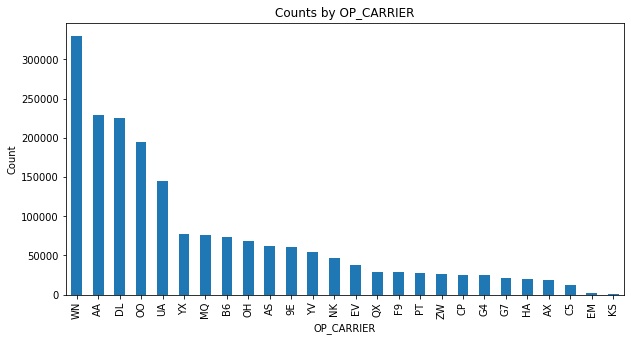

In [16]:
# Group by the 'ORIGIN' column and count the occurrences
origin_counts = flights['OP_CARRIER'].value_counts()

# Plot the counts for 'ORIGIN'
origin_counts.plot(kind='bar', figsize=(10,5))
plt.title('Counts by OP_CARRIER')
plt.xlabel('OP_CARRIER')
plt.ylabel('Count')
plt.show()

We can see there are no anomalies in these three columns

### Preprocessing for Numerical Data

we will focus on DISTANCE and OCCUPANCY_RATE, since they can help us calculate the revenue. 

We also need to check DEP_DELAY and ARR_DELAY as they are relevant to punctuality and delay cost

##### Distance

In [17]:
# Save the original 'DISTANCE' column
original_distance = flights['DISTANCE'].copy()

# Convert values that cannot be converted to numbers to NaN using 'errors='coerce''
flights['DISTANCE'] = pd.to_numeric(flights['DISTANCE'], errors='coerce')

# Find values in the original data that could not be converted to numbers
non_convertible_values = original_distance[flights['DISTANCE'].isna()]

# Output these values
print(non_convertible_values.dropna())

1910839    Hundred
1910862     Twenty
1910884        NAN
1910945        NAN
1910981       ****
            ...   
1911336       ****
1911337       ****
1911338       ****
1911339       ****
1911340       ****
Name: DISTANCE, Length: 211, dtype: object


In [18]:
# see the anamolies which are not number
non_convertible_values.dropna().value_counts()

****       207
NAN          2
Hundred      1
Twenty       1
Name: DISTANCE, dtype: int64

These are anomalies that cannot be converted to number, we changed them to nan, and will deal with nan value in missing value part

In [19]:
flights.DISTANCE.describe()

count    1.911067e+06
mean     7.681967e+02
std      5.794035e+02
min     -1.947000e+03
25%      3.420000e+02
50%      6.060000e+02
75%      1.010000e+03
max      9.898000e+03
Name: DISTANCE, dtype: float64

We see the negative value, we need change them to positive

In [20]:
flights['DISTANCE'] = flights['DISTANCE'].abs()

Checking Inconsistency: For the same ORIGIN and DESTINATION, they should have the same DISTANCE. We need to check this and deal with this

In [21]:
# Group the 'flights' DataFrame by 'ORIGIN' and 'DESTINATION' and count the unique 'DISTANCE' values
grouped = flights.groupby(['ORIGIN', 'DESTINATION'])['DISTANCE'].nunique()

# Convert the grouped Series to a DataFrame and reset the index
grouped_df = grouped.reset_index()

# Use boolean indexing to filter rows where the number of unique 'DISTANCE' values is greater than one
filtered_df = grouped_df[grouped_df['DISTANCE'] > 1]

# Find all the different 'DISTANCE' values for each ['ORIGIN', 'DESTINATION'] combination
unique_distances = flights.groupby(['ORIGIN', 'DESTINATION'])['DISTANCE'].unique().reset_index()

# Filter out rows where there are more than one different 'DISTANCE' values for each ['ORIGIN', 'DESTINATION'] combination
filtered_unique_distances = unique_distances[unique_distances['DISTANCE'].apply(len) > 1]

# Print the result
print(filtered_unique_distances)

     ORIGIN DESTINATION          DISTANCE
195     ATL         LAX     [1947.0, nan]
278     ATW         ORD    [161.0, 160.0]
363     AZA         DSM  [1138.0, 1137.0]
451     BHM         ORD    [583.0, 584.0]
605     BOS         ORD      [867.0, nan]
...     ...         ...               ...
5812    TUL         CLT      [842.0, nan]
5813    TUL         DAL    [237.0, 238.0]
5833    TUS         LAS    [364.0, 365.0]
5842    TUS         SAN    [367.0, 368.0]
5845    TUS         SJC    [721.0, 722.0]

[67 rows x 3 columns]


We are making an assumption here that we have more correct data than incorrect data. For the same ORIGIN and DESTINATION, we will use the most common 'DISTANCE' for each ('ORIGIN', 'DESTINATION') pair to correct the anomalies. This approach will also help us impute the mode to the NaN values.

In [22]:
# Calculate the most common 'DISTANCE' for each ['ORIGIN', 'DESTINATION'] combination
mode_distance = flights.groupby(['ORIGIN', 'DESTINATION'])['DISTANCE'].agg(lambda x: x.mode()[0]).reset_index()
mode_distance.columns = ['ORIGIN', 'DESTINATION', 'MODE_DISTANCE'] 

# Merge the original DataFrame with the DataFrame containing the most common 'DISTANCE'
flights = pd.merge(flights, mode_distance, on=['ORIGIN', 'DESTINATION'], how='left')

# Define a function that checks if the given 'DISTANCE' is the most common 'DISTANCE' for its corresponding ['ORIGIN', 'DESTINATION'] combination. If not, the function returns the most common 'DISTANCE'; otherwise, it returns the original 'DISTANCE'.
def replace_with_mode(row):
    if row['DISTANCE'] != row['MODE_DISTANCE']:
        return row['MODE_DISTANCE']
    else:
        return row['DISTANCE']

# Use the apply() function and this function to replace values in the 'DISTANCE' column
flights['DISTANCE'] = flights.apply(replace_with_mode, axis=1)

# Remove MODE_DISTANCE column
flights = flights.drop('MODE_DISTANCE', axis=1)

In [23]:
summarize_data(flights)

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
data_type,object,object,object,object,int64,object,object,int64,object,object,float64,float64,float64,object,float64,float64
missing_values,0,0,12111,0,0,0,0,0,0,0,50216,55847,0,55903,0,31
missing_values_percent,0.0,0.0,0.633639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.627265,2.921875,0.0,2.924805,0.0,0.001622


We can see that, in the process of dealing with anomalies, all the missing values were also imputed with mode

##### OCCUPANCY_RATE

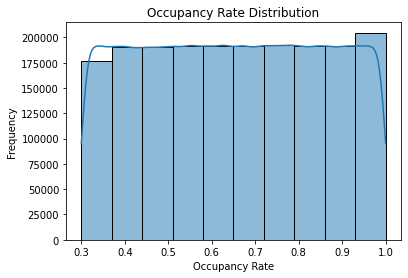

In [24]:
#plot the histogram of OCCUPANCY_RATE
sns.histplot(flights['OCCUPANCY_RATE'], bins=10, kde=True)
plt.title('Occupancy Rate Distribution')
plt.xlabel('Occupancy Rate')
plt.ylabel('Frequency')
plt.show()

Min is 0.3, max is 1, there is no strange value

In [25]:
# Calculate the number of missing values in the 'OCCUPANCY_RATE' column
missing_values = flights['OCCUPANCY_RATE'].isna().sum()

print(f"The number of missing values in the 'OCCUPANCY_RATE' column is: {missing_values}")

The number of missing values in the 'OCCUPANCY_RATE' column is: 31


In [26]:
missing_rows = flights[flights['OCCUPANCY_RATE'].isna()]

In [27]:
missing_rows.head()

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
1911187,3/1/19,AA,N918NN,1427,10721,BOS,"Boston, MA",13930,ORD,"Chicago, IL",-5.0,-5.0,0.0,$$$,867.0,NaN
1911188,3/3/19,AA,N887NN,1427,10721,BOS,"Boston, MA",13930,ORD,"Chicago, IL",-7.0,-7.0,0.0,$$$,867.0,NaN
1911189,3/4/19,AA,N856NN,1427,10721,BOS,"Boston, MA",13930,ORD,"Chicago, IL",241.0,270.0,0.0,143,867.0,NaN
1911190,3/5/19,AA,N342PM,1427,10721,BOS,"Boston, MA",13930,ORD,"Chicago, IL",-2.0,-2.0,0.0,143,867.0,NaN
1911191,3/6/19,AA,N964NN,1427,10721,BOS,"Boston, MA",13930,ORD,"Chicago, IL",25.0,8.0,0.0,133,867.0,NaN


It seems all OP_CARRIER, ORIGIN and DESTINATION all just have one value, let's check it

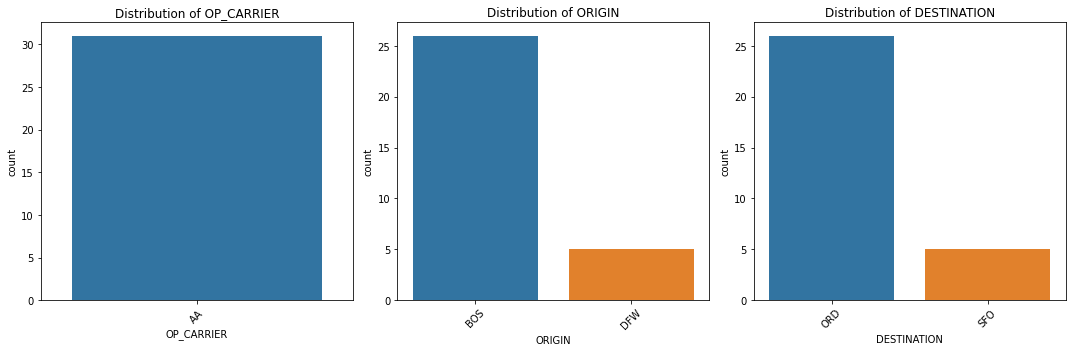

In [28]:
# Assuming 'missing_rows' is your DataFrame
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.countplot(x='OP_CARRIER', data=missing_rows, ax=axes[0])
axes[0].set_title('Distribution of OP_CARRIER')
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(x='ORIGIN', data=missing_rows, ax=axes[1])
axes[1].set_title('Distribution of ORIGIN')
axes[1].tick_params(axis='x', rotation=45)

sns.countplot(x='DESTINATION', data=missing_rows, ax=axes[2])
axes[2].set_title('Distribution of DESTINATION')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

We can see that all missing values in OCCUPANCY_RATE column are from same OP_CARRIER: AA

Considering that all missing values are for the airline "AA," I have decided to use the average OCCUPANCY_RATE of "AA" flights with same (ORIGIN, DESTINATION) pair to fill in the missing values.

In [29]:
# Select rows with "AA" as the value in the 'OP_CARRIER' column
flights_aa = flights[flights['OP_CARRIER'] == 'AA']

# Calculate the average OCCUPANCY_RATE for each pair of ORIGIN and DESTINATION
mean_values = flights_aa.groupby(['ORIGIN', 'DESTINATION'])['OCCUPANCY_RATE'].transform('mean')

# Fill missing values in the 'OCCUPANCY_RATE' column for 'AA' flights
flights.loc[flights['OP_CARRIER'] == 'AA', 'OCCUPANCY_RATE'] = flights_aa['OCCUPANCY_RATE'].fillna(mean_values)

In [30]:
summarize_data(flights)

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
data_type,object,object,object,object,int64,object,object,int64,object,object,float64,float64,float64,object,float64,float64
missing_values,0,0,12111,0,0,0,0,0,0,0,50216,55847,0,55903,0,0
missing_values_percent,0.0,0.0,0.633639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.627265,2.921875,0.0,2.924805,0.0,0.0


##### ARR_DELAY, DEP_DELAY

In [31]:
# check the column that we need to impute
print(sum(flights['ARR_DELAY'].isnull() & flights['DEP_DELAY'].notnull()))
print(sum(flights['ARR_DELAY'].notnull() & flights['DEP_DELAY'].isnull()))

5631
0


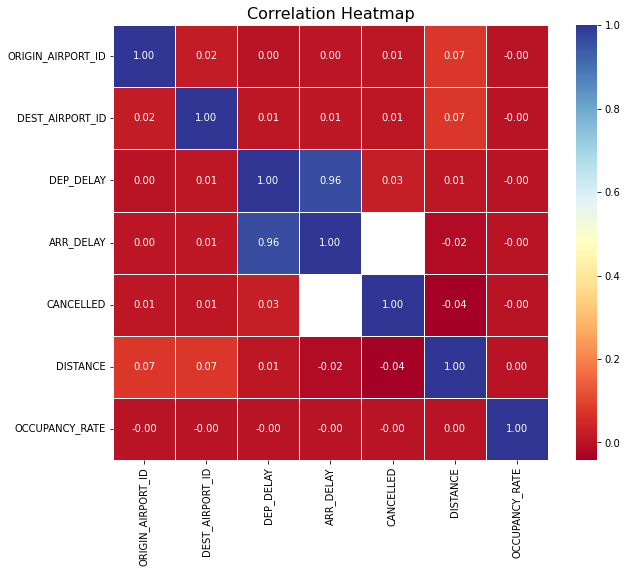

In [32]:
# Calculate the correlation matrix using flights.corr()
correlation_matrix = flights.corr()

# Create the correlation heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu', fmt='.2f', linewidths=0.5, square=True)
plt.title('Correlation Heatmap', fontsize=16)

plt.show()

We could find that the correlation between ARR_DELAY and DEP_DELAY is 0.96, so we could use linear regression to impute value

In [33]:
# Drop the rows with missing values in 'ARR_DELAY' or 'DEP_DELAY'
df = flights.dropna(subset=['ARR_DELAY', 'DEP_DELAY'])

# Get your independent and dependent variables
X = df['DEP_DELAY']
y = df['ARR_DELAY']

# Add a constant to the independent value
X = sm.add_constant(X)

# Conduct the ordinary least squares regression
model = sm.OLS(y, X)
results = model.fit()

# Print out the statistics
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              ARR_DELAY   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                 2.368e+07
Date:                Sun, 30 Jul 2023   Prob (F-statistic):               0.00
Time:                        22:29:18   Log-Likelihood:            -7.5472e+06
No. Observations:             1855494   AIC:                         1.509e+07
Df Residuals:                 1855492   BIC:                         1.509e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.1837      0.011   -488.456      0.0

In [34]:
# Get the rows with missing ARR_DELAY, not missing DEP_DELAY, and where CANCELLED is 0
missing_arr_delay = ((flights['ARR_DELAY'].isnull()) & 
                     (flights['DEP_DELAY'].notnull()) & 
                     (flights['CANCELLED'] == 0))

# Predict and fill ARR_DELAY for rows where it's missing, DEP_DELAY isn't missing, and CANCELLED is 0
flights.loc[missing_arr_delay, 'ARR_DELAY'] = results.predict(sm.add_constant(flights.loc[missing_arr_delay, 'DEP_DELAY']))

In [35]:
summarize_data(flights[flights["CANCELLED"]==0])

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
data_type,object,object,object,object,int64,object,object,int64,object,object,float64,float64,float64,object,float64,float64
missing_values,0,0,0,0,0,0,0,0,0,0,0,0,0,4433,0,0
missing_values_percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.238351,0.0,0.0


#### Outliers

In [36]:
#check whether these four columns are normally distributed
columns = ['DISTANCE', 'OCCUPANCY_RATE','DEP_DELAY', 'ARR_DELAY']
is_normally_distributed(flights,columns)

DISTANCE does not appear to be normally distributed (reject H0)
OCCUPANCY_RATE does not appear to be normally distributed (reject H0)
DEP_DELAY appears to be normally distributed (fail to reject H0)
ARR_DELAY appears to be normally distributed (fail to reject H0)


For DEP_DELAY:
  Number of outliers: 0
  Percentage of outliers: 0.0%
  Mean: 10.813566525622942
For ARR_DELAY:
  Number of outliers: 0
  Percentage of outliers: 0.0%
  Mean: 5.706629255973991


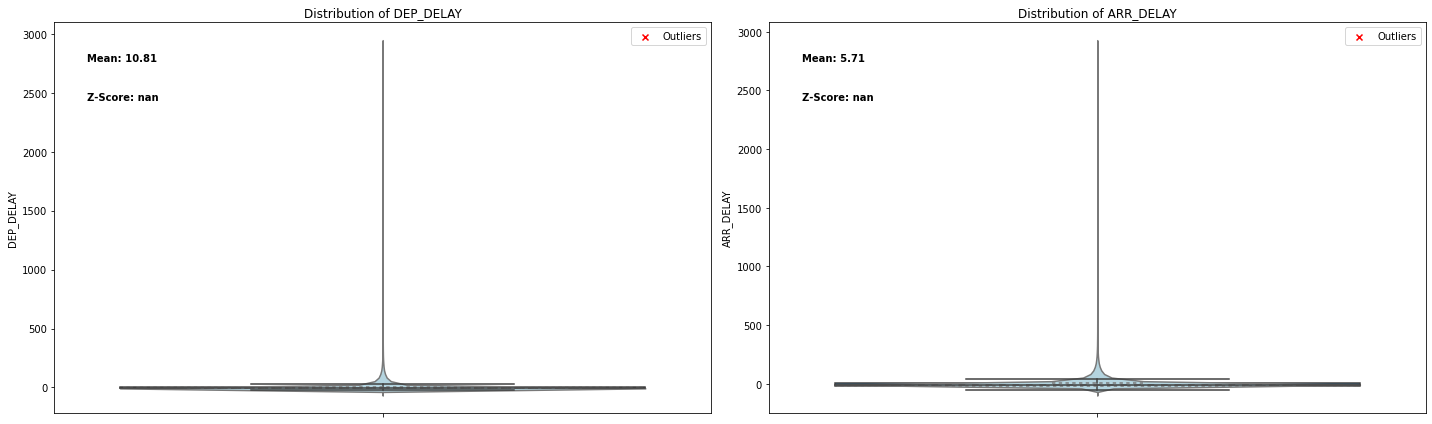

In [37]:
columns = ['DEP_DELAY', 'ARR_DELAY']

# Create a single figure and subplots for all columns
fig, axes = plt.subplots(1, len(columns), figsize=(20, 6))

for i, column in enumerate(columns):
    # Calculate Z-scores
    flights['z_score'] = stats.zscore(flights[column])

    # Define a threshold for outliers
    threshold = 3

    # Find all outliers
    outliers = flights[flights['z_score'].abs() > threshold]

    # Calculate the number and percentage of outliers
    num_outliers = len(outliers)
    percent_outliers = num_outliers / len(flights) * 100

    # Calculate the mean of the column
    column_mean = flights[column].mean()

    # Print the results
    print(f"For {column}:")
    print(f"  Number of outliers: {num_outliers}")
    print(f"  Percentage of outliers: {percent_outliers}%")
    print(f"  Mean: {column_mean}")

    # Create a combined plot with both box plot and violin plot
    sns.boxplot(data=flights, y=column, showfliers=False, ax=axes[i])
    sns.violinplot(data=flights, y=column, inner='quartile', color='lightblue', ax=axes[i])
    axes[i].scatter(outliers.index, outliers[column], c='red', marker='x', label='Outliers')
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_ylabel(column)
    axes[i].legend()

    # Add text annotations for mean and z-score on the plot
    axes[i].text(0.05, 0.9, f"Mean: {column_mean:.2f}", transform=axes[i].transAxes, fontsize=10, fontweight='bold')
    axes[i].text(0.05, 0.8, f"Z-Score: {flights['z_score'].mean():.2f}", transform=axes[i].transAxes, fontsize=10, fontweight='bold')

# Drop the 'z_score' column after analysis
flights.drop('z_score', axis=1, inplace=True)

plt.tight_layout()
plt.show()

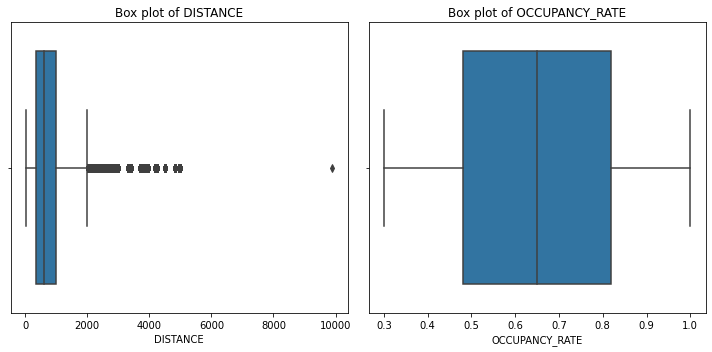

In [38]:
def plot_outliers(df, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(len(columns) * 5, 5))

    for i, column_name in enumerate(columns):
        sns.boxplot(x=df[column_name], ax=axes[i])
        axes[i].set_title('Box plot of ' + column_name)

    plt.tight_layout()
    plt.show()

# Example usage
tickets_columns = ['DISTANCE', 'OCCUPANCY_RATE']
plot_outliers(flights, tickets_columns)

So, we only see the outlier of Distance. If we check the table, we can see that the large distance is reasonable, like from HI to NY, the distance is 4983 miles, so we don't need to deal with the outliers

In [39]:
flights=flights[flights["CANCELLED"]==0]

## Airport_Codes <a name="table2"></a>

We use this table to identify whether an airport is considered medium or large-sized in the US. For this table, we only need three columns: TYPE, ISO_COUNTRY, and IATA_CODE. All three are categorical variables. The first two are used to identify whether an airport is considered medium or large-sized in the US, and IATA_CODE is used to connect other tables.

In [40]:
# Reading the CSV file 'Airport_Codes.csv' into a DataFrame 'airport_codes',
airport_codes = pd.read_csv("Airport_Codes.csv",low_memory=False)

In [41]:
summarize_data(airport_codes)

,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
data_type,object,object,float64,object,object,object,object,object
missing_values,0,0,7015,27843,247,5706,46187,0
missing_values_percent,0.0,0.0,12.669544,50.286261,0.446098,10.305406,83.416713,0.0


#### Duplicate

In [42]:
# check the duplicates
num_duplicates = df.duplicated().sum()
num_duplicates

0

We make an assumption that all US large and medium airports shown in the flights table can be found in the airport_codes table.   
Let's check our assumption

In [43]:
# Check the number of airports in the United States in the airport_codes table.
len(airport_codes[airport_codes["ISO_COUNTRY"]=="US"])

22810

There are around 20,000 airports in the U.S.
https://www.usatoday.com/story/travel/news/2022/10/15/what-is-the-busiest-airport/10341892002/

Based on the information provided in the link, where it's stated that there are around 20,000 airports in the United States, and the number obtained from our table is 22,810, we can reasonably assume that all American airports shown in the flights table could be found in the airport_codes table.

##### TYPE

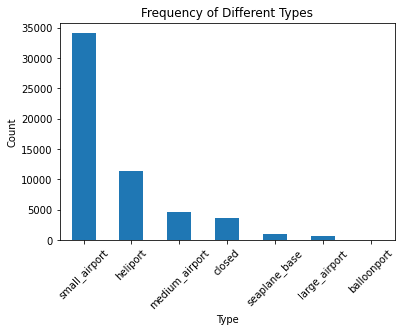

In [44]:
# Check the TYPE column to see if there are strange value
# Get the value counts for the 'TYPE' column
type_counts = airport_codes['TYPE'].value_counts()

# Plot the value counts as a bar plot
type_counts.plot(kind='bar')
plt.title('Frequency of Different Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

There is no strange value and no missing valuein TYPE column

In [45]:
# Check the medium_airport and large_airport
df = airport_codes[(airport_codes["TYPE"] == "medium_airport") | (airport_codes["TYPE"] == "large_airport")]

##### ISO_COUNTRY

In [46]:
summarize_data(df)

,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
data_type,object,object,float64,object,object,object,object,object
missing_values,0,0,204,1448,12,535,687,0
missing_values_percent,0.0,0.0,3.964244,28.13836,0.233191,10.396424,13.350175,0.0


Let us check if there are any airports without a specified country in the airport_codes table that belong to the United States. If there are, we need to fill in the missing values accordingly

In [47]:
# check the null value in ISO_COUNTRY column 
df[df["ISO_COUNTRY"].isnull()]

,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
21515,medium_airport,Arandis Airport,1905.0,AF,NaN,Arandis,ADI,"14.979999542236328, -22.462200164794922"
21524,medium_airport,Grootfontein Airport,4636.0,AF,NaN,Grootfontein,GFY,"18.122699737548828, -19.60219955444336"
21538,medium_airport,Keetmanshoop Airport,3506.0,AF,NaN,Keetmanshoop,KMP,"18.111400604248047, -26.5398006439209"
21540,medium_airport,Luderitz Airport,457.0,AF,NaN,Luderitz,LUD,"15.242899894714355, -26.687400817871094"
21545,medium_airport,Mariental Airport,3650.0,AF,NaN,Mariental,NaN,"17.925399780273438, -24.60540008544922"
21548,medium_airport,Ondangwa Airport,3599.0,AF,NaN,Ondangwa,OND,"15.9526, -17.878201"
21550,medium_airport,Oranjemund Airport,14.0,AF,NaN,Oranjemund,OMD,"16.446699, -28.5847"
21564,medium_airport,Rundu Airport,3627.0,AF,NaN,Rundu,NDU,"19.719400405884, -17.956499099731"
21575,medium_airport,Tsumeb Airport,4353.0,AF,NaN,Tsumeb,TSB,"17.732500076294, -19.26189994812"
21577,medium_airport,Walvis Bay Airport,299.0,AF,NaN,Walvis Bay,WVB,"14.6453, -22.9799"


They are all African airports, not US airports, so we can ignore these airports

Now we get a conclusion, in airport_codes table, we have all medium and large airports we want in the United States

In [48]:
# Narrowing down the data to what we need to analyze
df = df[df["ISO_COUNTRY"]=="US"]

In [49]:
summarize_data(df)

,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
data_type,object,object,float64,object,object,object,object,object
missing_values,0,0,3,858,0,3,37,0
missing_values_percent,0.0,0.0,0.34965,100.0,0.0,0.34965,4.312354,0.0


##### IATA_CODE

There are 37 missing values in the IATA_CODE column; let's check if we need to deal with them.

In [50]:
df[df["IATA_CODE"].isnull()]

,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
25963,medium_airport,South Alabama Regional At Bill Benton Field Ai...,310.0,NaN,US,Andalusia/Opp,NaN,"-86.393799, 31.3088"
27145,medium_airport,Shelby County Airport,586.0,NaN,US,Alabaster,NaN,"-86.78279877, 33.17699814"
27517,medium_airport,Wheeler Sack Army Air Field,688.0,NaN,US,Fort Drum,NaN,"-75.71949768, 44.05559921"
27648,medium_airport,Hurlburt Field,38.0,NaN,US,Mary Esther,NaN,"-86.68930053710938, 30.427799224853516"
27685,medium_airport,San Marcos Regional Airport,597.0,NaN,US,San Marcos,NaN,"-97.862999, 29.8927"
27822,medium_airport,Julian Carroll Airport,1381.0,NaN,US,Jackson,NaN,"-83.31729888916016, 37.59389877319336"
27979,medium_airport,Monticello Municipal Ellis Field,270.0,NaN,US,Monticello,NaN,"-91.75099945, 33.6385994"
28221,medium_airport,Mc Minnville Municipal Airport,163.0,NaN,US,Mc Minnville,NaN,"-123.1360016, 45.19440079"
28345,medium_airport,Beaufort MCAS - Merritt Field,37.0,NaN,US,Beaufort,NaN,"-80.723197937, 32.4774017334"
28348,medium_airport,New River MCAS /H/ /Mccutcheon Fld/ Airport,26.0,NaN,US,Jacksonville,NaN,"-77.43969727, 34.70840073"


For those airports without the MUNICIPALITY, 'Yuma Auxiliary AAF # 2' and '34S Airport' seem to be strange values. 'ATL' may be the IATA_CODE, so let's check it

In [51]:
airport_codes[airport_codes["IATA_CODE"]=="ATL"]

,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
26266,large_airport,Hartsfield Jackson Atlanta International Airport,1026.0,NaN,US,Atlanta,ATL,"-84.428101, 33.6367"


We already have the IATA_CODE 'ATL', so we can eliminate these three airports

In [52]:
# Drop rows where 'MUNICIPALITY' is NaN
df = df.dropna(subset=['MUNICIPALITY'])

Now let's deal with the other 34 airports without an IATA_CODE.

If these 34 airports show up in the flights table frequently, we need to address them.

In [53]:
# Filter out rows where "MUNICIPALITY" or "IATA_CODE" is NaN
municipalities = df[df["IATA_CODE"].isnull()]["MUNICIPALITY"].dropna()

for i in municipalities:
    # Check if 'i' is in the 'ORIGIN_CITY_NAME' column and count the occurrences
    origin_occurrences = flights['ORIGIN_CITY_NAME'].str.contains(i, na=False, case=False).sum()

    # Check if 'i' is in the 'DEST_CITY_NAME' column and count the occurrences
    dest_occurrences = flights['DEST_CITY_NAME'].str.contains(i, na=False, case=False).sum()

    # If 'i' is in either column, print it and the total occurrences
    if origin_occurrences > 0 or dest_occurrences > 0:
        print(f"'{i}' appears in flights table {origin_occurrences + dest_occurrences} times.")


'Jackson' appears in flights table 24921 times.
'Beaufort' appears in flights table 1337 times.
'Jacksonville' appears in flights table 18230 times.
'Corpus Christi' appears in flights table 2661 times.
'Meridian' appears in flights table 523 times.
'Columbus' appears in flights table 24108 times.
'Atlanta' appears in flights table 185692 times.
'Williston' appears in flights table 985 times.


We can notice that only these eight places appear in the flights table. Let's impute the IATA_CODE for them and ignore the other airports without an IATA_CODE.

But among these eight airports, only Cobb County-McCollum Field has an IATA_CODE of 'RYY', so let's ignore the others.

In [54]:
# Impute the missing value
df.loc[49837,"IATA_CODE"]="RYY"

# Drop rows where IATA_CODE is still NaN
df = df.dropna(subset=['IATA_CODE'])

Check the anomalies in the IATA_CODE column

In [55]:
# Define a regular expression to match all strings consisting of three letters.
pattern = r'^[A-Za-z]{3}$'

# Check the 'IATA_CODE' column.
iatacode_anomalies = find_anomalies(pattern, df, "IATA_CODE")


IATA_CODE anomalies:
Empty DataFrame
Columns: [TYPE, NAME, ELEVATION_FT, CONTINENT, ISO_COUNTRY, MUNICIPALITY, IATA_CODE, COORDINATES]
Index: []


There are no anomalies in the IATA_CODE column of the airport_codes table

In [56]:
summarize_data(df)

,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
data_type,object,object,float64,object,object,object,object,object
missing_values,0,0,0,822,0,0,0,0
missing_values_percent,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0


In [57]:
airport_codes = df

## Tickets <a name="table3"></a>

This table contains ticket prices data, we need to use it to connect with other tables and get the ININ_FARE

In [58]:
# Reading the CSV file 'Tickets.csv' into a DataFrame 'tickets',
tickets = pd.read_csv("Tickets.csv",low_memory=False)

#### Duplicate

In [59]:
# check the duplicates
num_duplicates = tickets.duplicated().sum()
print(len(tickets))
print(num_duplicates)

# Eliminate the duplicates
tickets = tickets.drop_duplicates()

1167285
71898


In [60]:
summarize_data(tickets)

,ITIN_ID,YEAR,QUARTER,ORIGIN,ORIGIN_COUNTRY,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
data_type,int64,int64,int64,object,object,object,object,float64,object,float64,object,object
missing_values,0,0,0,0,0,0,0,0,0,1575,787,0
missing_values_percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.143785,0.071847,0.0


# Preprocessing for Catergorical Data

For categorical variables, we need ORIGIN, DESTINATION, and REPORTING_CARRIER. ORIGIN and DESTINATION are the airport's IATA code, which can help us merge with the other two tables. REPORTING_CARRIER can help us analyze different airlines.

We also need to check ROUNDTRIP, since we only consider round trip

Let's check the anomalies first

In [61]:
# Define a regular expression that matches strings composed of 3 characters 
pattern = r'^[A-Za-z]{3}$'

# Check the 'ORIGIN' column
origin_anomalies = find_anomalies(pattern, tickets, "ORIGIN")

# Check the 'DESTINATION' column
destination_anomalies = find_anomalies(pattern, tickets, "DESTINATION")


ORIGIN anomalies:
Empty DataFrame
Columns: [ITIN_ID, YEAR, QUARTER, ORIGIN, ORIGIN_COUNTRY, ORIGIN_STATE_ABR, ORIGIN_STATE_NM, ROUNDTRIP, REPORTING_CARRIER, PASSENGERS, ITIN_FARE, DESTINATION]
Index: []

DESTINATION anomalies:
Empty DataFrame
Columns: [ITIN_ID, YEAR, QUARTER, ORIGIN, ORIGIN_COUNTRY, ORIGIN_STATE_ABR, ORIGIN_STATE_NM, ROUNDTRIP, REPORTING_CARRIER, PASSENGERS, ITIN_FARE, DESTINATION]
Index: []


In [62]:
# Define a regular expression that matches strings composed of 2 characters (letters or numbers)
pattern = r'^[A-Za-z0-9]{2}$'

# Check the 'REPORTING_CARRIER' column
carrier_anomalies = find_anomalies(pattern, tickets, 'REPORTING_CARRIER')


REPORTING_CARRIER anomalies:
Empty DataFrame
Columns: [ITIN_ID, YEAR, QUARTER, ORIGIN, ORIGIN_COUNTRY, ORIGIN_STATE_ABR, ORIGIN_STATE_NM, ROUNDTRIP, REPORTING_CARRIER, PASSENGERS, ITIN_FARE, DESTINATION]
Index: []


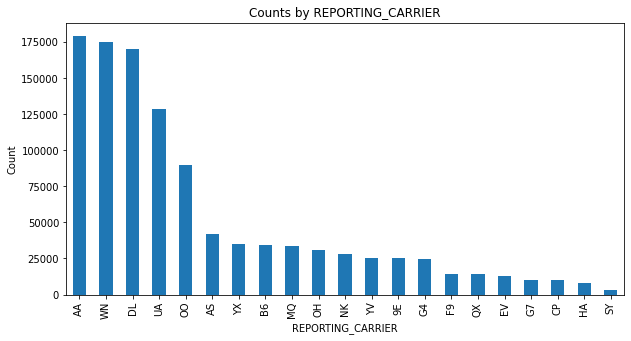

In [63]:
# Group by the 'ORIGIN' column and count the occurrences
origin_counts = tickets['REPORTING_CARRIER'].value_counts()

# Plot the counts for 'ORIGIN'
origin_counts.plot(kind='bar', figsize=(10,5))
plt.title('Counts by REPORTING_CARRIER')
plt.xlabel('REPORTING_CARRIER')
plt.ylabel('Count')
plt.show()

We can see, for these three columns, there is no anomalies and no missing value

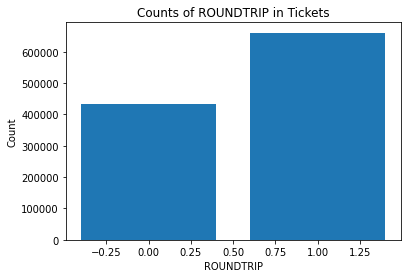

In [64]:
# Get the value counts of each value in the "ROUNDTRIP" column
roundtrip_counts = tickets["ROUNDTRIP"].value_counts()

# Create the bar plot
plt.bar(roundtrip_counts.index, roundtrip_counts.values)

# Add labels and title
plt.xlabel("ROUNDTRIP")
plt.ylabel("Count")
plt.title("Counts of ROUNDTRIP in Tickets")

# Show the plot
plt.show()

So we can know the ROUNDTRIP column has no issue.

There is no issue in these four categorical columns we need

In [65]:
tickets = tickets[tickets["ROUNDTRIP"]==1]

# Preprocessing for Numerical Data

For numerical data, we need to handle ITIN_FARE, which is the columns relevant to our revenue

In [66]:
summarize_data(tickets)

,ITIN_ID,YEAR,QUARTER,ORIGIN,ORIGIN_COUNTRY,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
data_type,int64,int64,int64,object,object,object,object,float64,object,float64,object,object
missing_values,0,0,0,0,0,0,0,0,0,960,451,0
missing_values_percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.145227,0.068226,0.0


In [67]:
# Find the rows in 'ITIN_FARE' that cannot be converted to a number
invalid_rows = pd.to_numeric(tickets['ITIN_FARE'], errors='coerce').isna()

# Check the invalid data
tickets[invalid_rows].ITIN_FARE.value_counts()

200 $       677
$ 100.00    273
820$$$      256
Name: ITIN_FARE, dtype: int64

We can see there are some extra '$' symbols and spaces, so we will remove the dollar symbol.

In [68]:
# Make a copy of the 'ITIN_FARE' series
itin_fare = tickets['ITIN_FARE'].copy()

# Convert the series to string type
itin_fare = itin_fare.astype(str)

# Remove all "$" and spaces
itin_fare = itin_fare.replace({'\$': '', ' ': ''}, regex=True)

# Replace 'nan' strings with actual NaN values
itin_fare[itin_fare == 'nan'] = pd.NA

# Convert the series back to numeric, leaving non-numeric strings as NaN
itin_fare = pd.to_numeric(itin_fare, errors='coerce')

# Replace the original 'ITIN_FARE' column with the cleaned series
tickets['ITIN_FARE'] = itin_fare

In [69]:
summarize_data(tickets)

,ITIN_ID,YEAR,QUARTER,ORIGIN,ORIGIN_COUNTRY,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
data_type,int64,int64,int64,object,object,object,object,float64,object,float64,float64,object
missing_values,0,0,0,0,0,0,0,0,0,960,451,0
missing_values_percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.145227,0.068226,0.0


We first fill the missing values with the average ITIN_FARE for the same pair of ORIGIN and DESTINATION, and if there are still missing values, we fill them using the average ITIN_FARE for the same REPORTING_CARRIER

In [70]:
# Compute the average ITIN_FARE for each pair of ORIGIN and DESTINATION
average_fares = tickets.groupby(['ORIGIN', 'DESTINATION'])['ITIN_FARE'].mean().reset_index()

# Rename the new column for merging
average_fares = average_fares.rename(columns={'ITIN_FARE': 'AVERAGE_FARE'})

# Merge the average fares back into the original DataFrame
tickets = pd.merge(tickets, average_fares, on=['ORIGIN', 'DESTINATION'], how='left')

# Use the AVERAGE_FARE column to fill the missing values in ITIN_FARE
tickets['ITIN_FARE'] = tickets['ITIN_FARE'].fillna(tickets['AVERAGE_FARE'])

# Optionally, drop the AVERAGE_FARE column if it's no longer needed
tickets = tickets.drop(columns='AVERAGE_FARE')

In [71]:
# Compute the average ITIN_FARE for each REPORTING_CARRIER
average_fares_carrier = tickets.groupby('REPORTING_CARRIER')['ITIN_FARE'].mean().reset_index()

# Rename the new column for merging
average_fares_carrier = average_fares_carrier.rename(columns={'ITIN_FARE': 'AVERAGE_FARE_CARRIER'})

# Merge the average fares back into the original DataFrame
tickets = pd.merge(tickets, average_fares_carrier, on='REPORTING_CARRIER', how='left')

# Use the AVERAGE_FARE_CARRIER column to fill the remaining missing values in ITIN_FARE
tickets['ITIN_FARE'] = tickets['ITIN_FARE'].fillna(tickets['AVERAGE_FARE_CARRIER'])

# Optionally, drop the AVERAGE_FARE_CARRIER column if it's no longer needed
tickets = tickets.drop(columns='AVERAGE_FARE_CARRIER')


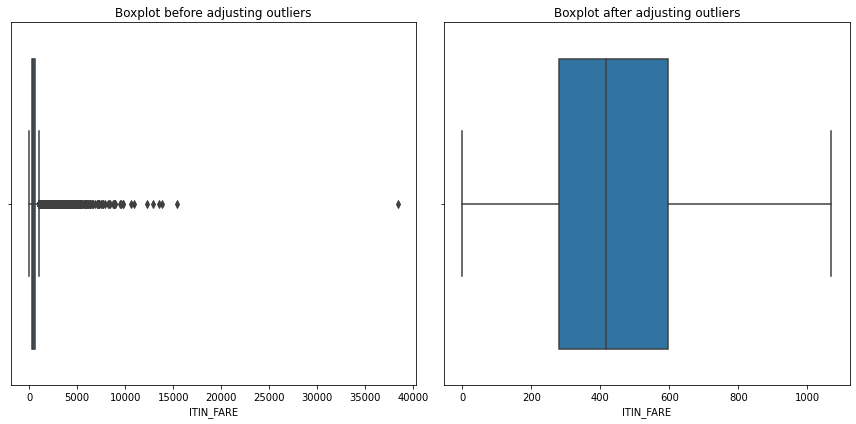

In [72]:
tickets = adjust_and_plot_outliers_using_iqr(tickets,"ITIN_FARE")

# Problem Solving <a name="problems"></a>

We will join the data in the process of solving these problems, which would be more easy to understand

## Problem 1: Busiest Routes <a name="problem1"></a>
The 10 busiest round trip routes in terms of number of round trip flights in the quarter.
Exclude canceled flights when performing the calculation.

In [73]:
# Create a new DataFrame that only includes the IATA_CODE and TYPE columns
airport_codes_temp = airport_codes[['IATA_CODE', 'TYPE']]

# Merge with starting airport information
df = pd.merge(flights, airport_codes_temp, how='inner', left_on='ORIGIN', right_on='IATA_CODE')
df.rename(columns={'TYPE': 'TYPE_ORIGIN'}, inplace=True)

# Merge with destination airport information
df = pd.merge(df, airport_codes_temp, how='inner', left_on='DESTINATION', right_on='IATA_CODE')
df.rename(columns={'TYPE': 'TYPE_DEST'}, inplace=True)

# Drop unnecessary columns
df.drop(columns=['IATA_CODE_x', 'IATA_CODE_y'], inplace=True)

In [74]:
df

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE,TYPE_ORIGIN,TYPE_DEST
0,2019-03-02,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-8.0,-6.0,0.0,143.0,1025.0,0.97,large_airport,large_airport
1,2019-03-09,WN,N754SW,3016,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-7.0,-22.0,0.0,137.0,1025.0,0.63,large_airport,large_airport
2,2019-03-24,UA,N14249,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-16.0,-9.0,0.0,129.0,1025.0,0.98,large_airport,large_airport
3,2019-03-11,UA,N14240,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-1.0,8.0,0.0,138.0,1025.0,0.36,large_airport,large_airport
4,2019-03-10,UA,N11206,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-6.0,1.0,0.0,141.0,1025.0,0.45,large_airport,large_airport
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1828042,2019-01-25,G4,317NV,502,10466,AZA,"Phoenix, AZ",13829,OGD,"Ogden, UT",88.0,86.0,0.0,79.0,544.0,0.71,medium_airport,medium_airport
1828043,2019-01-07,G4,255NV,502,10466,AZA,"Phoenix, AZ",13829,OGD,"Ogden, UT",70.0,74.0,0.0,84.0,544.0,0.36,medium_airport,medium_airport
1828044,2019-01-28,G4,317NV,502,10466,AZA,"Phoenix, AZ",13829,OGD,"Ogden, UT",-5.0,2.0,0.0,89.0,544.0,0.61,medium_airport,medium_airport
1828045,2019-01-11,G4,248NV,502,10466,AZA,"Phoenix, AZ",13829,OGD,"Ogden, UT",-6.0,6.0,0.0,92.0,544.0,0.54,medium_airport,medium_airport


Now we get the data we need to analyze

For the busiest round trips, we can use either airplane numbers or passenger numbers as the indicator. I have decided to use the passenger number since it is more related to our profit. Having 1000 airplanes with a total of 1000 passengers is not as good as having 100 airplanes with a total of 10000 passengers

From the instructions we received, the following assumptions can be made:

Each plane can accommodate up to 200 passengers, and each flight has an associated occupancy rate provided in the Flights dataset.

Since passenger numbers = 200 * Occupancy_rate, I will use this to create a new column: PASSENGER_NUMBER

In [75]:
PASSENGER_CAPACITY = 200
df["PASSENGER_NUMBER"] = PASSENGER_CAPACITY * df["OCCUPANCY_RATE"]

In [76]:
# Create a new column with the sorted ORIGIN and DESTINATION values
df['ROUTE'] = df.apply(lambda row: tuple(sorted([row['ORIGIN'], row['DESTINATION']])), axis=1)

In [77]:
# Group by the new column and sum the PASSENGER_NUMBER
grouped_df = df.groupby('ROUTE')['PASSENGER_NUMBER'].sum().reset_index()

grouped_df

,ROUTE,PASSENGER_NUMBER
0,"(ABE, ATL)",56796.0
1,"(ABE, CLT)",66374.0
2,"(ABE, DTW)",64152.0
3,"(ABE, FLL)",4842.0
4,"(ABE, ORD)",41542.0
...,...,...
2823,"(STL, TPA)",55444.0
2824,"(STL, TUL)",42010.0
2825,"(SYR, TPA)",8864.0
2826,"(TPA, TTN)",20078.0


In [78]:
# Sort the DataFrame by PASSENGER_NUMBER in descending order
grouped_df = grouped_df.sort_values(by='PASSENGER_NUMBER', ascending=False)

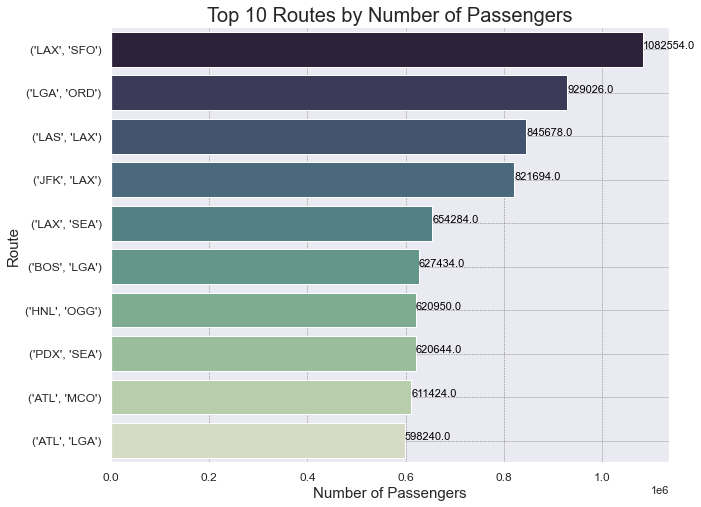

In [79]:
# Set a theme for the plot
sns.set_theme()

# Set the color palette
colors = sns.cubehelix_palette(10, start=.5, rot=-.75, reverse=True)

# Take the top 10 routes
top_routes = grouped_df.head(10)

# Plot the data
plt.figure(figsize=(10, 8))
barplot = sns.barplot(x=top_routes['PASSENGER_NUMBER'], y=top_routes['ROUTE'].astype(str), palette=colors)
plt.xlabel('Number of Passengers', fontsize=15)
plt.ylabel('Route', fontsize=15)
plt.title('Top 10 Routes by Number of Passengers', fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add numbers on each bar
for i in barplot.patches:
    barplot.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()), 2)), fontsize=11, color='black')

plt.show()

In [80]:
grouped_df[0:10]

,ROUTE,PASSENGER_NUMBER
2162,"(LAX, SFO)",1082554.0
2203,"(LGA, ORD)",929026.0
2066,"(LAS, LAX)",845678.0
2010,"(JFK, LAX)",821694.0
2161,"(LAX, SEA)",654284.0
550,"(BOS, LGA)",627434.0
1772,"(HNL, OGG)",620950.0
2618,"(PDX, SEA)",620644.0
193,"(ATL, MCO)",611424.0
189,"(ATL, LGA)",598240.0


## Problem 2: Most Profitable Routes <a name="problem2"></a>
The 10 most profitable round trip routes (without considering the upfront airplane cost) in
the quarter. Along with the profit, show total revenue, total cost, summary values of other
key components and total round trip flights in the quarter for the top 10 most profitable
routes. Exclude canceled flights from these calculations.

### Cost
1. Fuel, Oil, Maintenance, Crew - `$8` per mile total  


2. Depreciation, Insurance, Other - `$1.18` per mile total  


3. Airport operational costs for the right to use the airports and related services are fixed at `$5,000` for medium airports and   
`$10,000` for large airports. There is one charge for each airport where a flight lands. Thus, a round-trip flight has a total of
two airport charges  


4. Delays that are 15 minutes or less are free, however each additional minute of
delay costs the airline `$75` in added operational costs. This is charged separately
for both arrival and departure delays   


5. Each airplane will cost `$90` million (this is upfront airplane cost, so we will not consider it this time)  

#### Calculation
For cost, we have 

OPERATING_COST =  $8 per mile * DISTANCE

OWNERSHIP_COST = $1.18 per mile * DISTANCE

AIRPORT_OPERATIONAL_COST = {
    'medium': 5000, 
    'large': 10000
}




DELAY_COST_PER_MINUTE = 75  (the cost incurred for each minute of delay)

FREE_DELAY_MINUTES = 15  (the allowable delay time in minutes that is free of charge)

DELAY_COST = MAX(ARR_DELAY - FREE_DELAY_MINUTES , 0) * DELAY_COST_PER_MINUTE + MAX(DEP_DELAY - FREE_DELAY_MINUTES,0) * DELAY_COST_PER_MINUTE

Now, let's create new columns for cost

In [81]:
df.head()

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE,TYPE_ORIGIN,TYPE_DEST,PASSENGER_NUMBER,ROUTE
0,2019-03-02,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-8.0,-6.0,0.0,143.0,1025.0,0.97,large_airport,large_airport,194.0,"(CLE, RSW)"
1,2019-03-09,WN,N754SW,3016,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-7.0,-22.0,0.0,137.0,1025.0,0.63,large_airport,large_airport,126.0,"(CLE, RSW)"
2,2019-03-24,UA,N14249,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-16.0,-9.0,0.0,129.0,1025.0,0.98,large_airport,large_airport,196.0,"(CLE, RSW)"
3,2019-03-11,UA,N14240,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-1.0,8.0,0.0,138.0,1025.0,0.36,large_airport,large_airport,72.0,"(CLE, RSW)"
4,2019-03-10,UA,N11206,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-6.0,1.0,0.0,141.0,1025.0,0.45,large_airport,large_airport,90.0,"(CLE, RSW)"


In [82]:
# All costs except airport_cost (airport_cost has already been calculated twice: origin and destination) need to be multiplied by 2, since it is round trip

# Calculate operating_cost
df['OPERATING_COST'] = df['DISTANCE'] * (8 + 1.18) * 2

# Calculate delay_cost
df['DEP_DELAY_COST'] = df['DEP_DELAY'].apply(lambda x: max(0, x - 15) * 75)  
df['ARR_DELAY_COST'] = df['ARR_DELAY'].apply(lambda x: max(0, x - 15) * 75)  
df['DELAY_COST'] = (df['DEP_DELAY_COST'] + df['ARR_DELAY_COST']) * 2


# Define a dictionary to map airport types to operational costs
AIRPORT_OPERATIONAL_COST = {'medium_airport': 5000, 'large_airport': 10000}

# Use the dictionary to replace the values in the TYPE_ORIGIN and TYPE_DEST columns
df['airport_operational_cost_origin'] = df['TYPE_ORIGIN'].map(AIRPORT_OPERATIONAL_COST)
df['airport_operational_cost_dest'] = df['TYPE_DEST'].map(AIRPORT_OPERATIONAL_COST)

# Calculate the operational cost for each flight (sum of costs for both airports)
df['AIRPORT_COST'] = (df['airport_operational_cost_origin'] + df['airport_operational_cost_dest'])


# Total cost is the sum of all the individual costs
df['TOTAL_COST'] = df['OPERATING_COST'] + df['DELAY_COST'] + df['AIRPORT_COST']

In [83]:
df.head()

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,...,PASSENGER_NUMBER,ROUTE,OPERATING_COST,DEP_DELAY_COST,ARR_DELAY_COST,DELAY_COST,airport_operational_cost_origin,airport_operational_cost_dest,AIRPORT_COST,TOTAL_COST
0,2019-03-02,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,194.0,"(CLE, RSW)",18819.0,0.0,0.0,0.0,10000,10000,20000,38819.0
1,2019-03-09,WN,N754SW,3016,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,126.0,"(CLE, RSW)",18819.0,0.0,0.0,0.0,10000,10000,20000,38819.0
2,2019-03-24,UA,N14249,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,196.0,"(CLE, RSW)",18819.0,0.0,0.0,0.0,10000,10000,20000,38819.0
3,2019-03-11,UA,N14240,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,72.0,"(CLE, RSW)",18819.0,0.0,0.0,0.0,10000,10000,20000,38819.0
4,2019-03-10,UA,N11206,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,90.0,"(CLE, RSW)",18819.0,0.0,0.0,0.0,10000,10000,20000,38819.0


### Revenue

Now, let's calculate the revenue. We first need to use the ITIN_FARE data in the tickets table to get the ticket price, and then we can determine the revenue

In [84]:
# Create a new column with the sorted ORIGIN and DESTINATION values
tickets['ROUTE'] = tickets.apply(lambda row: tuple(sorted([row['ORIGIN'], row['DESTINATION']])), axis=1)

# In the tickets DataFrame, group by ROUTE and calculate average ITIN_FARE
average_fares = tickets.groupby('ROUTE')['ITIN_FARE'].mean().reset_index()

# Rename the ITIN_FARE column to 'AVERAGE_FARE'
average_fares.rename(columns={'ITIN_FARE': 'AVERAGE_FARE'}, inplace=True)

# Merge average_fares back into df
df = pd.merge(df, average_fares, on='ROUTE', how='left')

In [85]:
summarize_data(df)

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,...,ROUTE,OPERATING_COST,DEP_DELAY_COST,ARR_DELAY_COST,DELAY_COST,airport_operational_cost_origin,airport_operational_cost_dest,AIRPORT_COST,TOTAL_COST,AVERAGE_FARE
data_type,object,object,object,object,int64,object,object,int64,object,object,...,object,float64,float64,float64,float64,int64,int64,int64,float64,float64
missing_values,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8355
missing_values_percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.457045


We use the KNN to impute the AVERAGE_FARE based on average_fare of the closest DISTANCE

In [86]:
columns = ["DISTANCE","AVERAGE_FARE"]

impute_missing_values_with_knn(df, columns, 3)

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,...,ROUTE,OPERATING_COST,DEP_DELAY_COST,ARR_DELAY_COST,DELAY_COST,airport_operational_cost_origin,airport_operational_cost_dest,AIRPORT_COST,TOTAL_COST,AVERAGE_FARE
0,2019-03-02,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,"(CLE, RSW)",18819.00,0.0,0.0,0.0,10000,10000,20000,38819.00,296.581761
1,2019-03-09,WN,N754SW,3016,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,"(CLE, RSW)",18819.00,0.0,0.0,0.0,10000,10000,20000,38819.00,296.581761
2,2019-03-24,UA,N14249,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,"(CLE, RSW)",18819.00,0.0,0.0,0.0,10000,10000,20000,38819.00,296.581761
3,2019-03-11,UA,N14240,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,"(CLE, RSW)",18819.00,0.0,0.0,0.0,10000,10000,20000,38819.00,296.581761
4,2019-03-10,UA,N11206,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,"(CLE, RSW)",18819.00,0.0,0.0,0.0,10000,10000,20000,38819.00,296.581761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1828042,2019-01-25,G4,317NV,502,10466,AZA,"Phoenix, AZ",13829,OGD,"Ogden, UT",...,"(AZA, OGD)",9987.84,5475.0,5325.0,21600.0,5000,5000,10000,41587.84,141.609756
1828043,2019-01-07,G4,255NV,502,10466,AZA,"Phoenix, AZ",13829,OGD,"Ogden, UT",...,"(AZA, OGD)",9987.84,4125.0,4425.0,17100.0,5000,5000,10000,37087.84,141.609756
1828044,2019-01-28,G4,317NV,502,10466,AZA,"Phoenix, AZ",13829,OGD,"Ogden, UT",...,"(AZA, OGD)",9987.84,0.0,0.0,0.0,5000,5000,10000,19987.84,141.609756
1828045,2019-01-11,G4,248NV,502,10466,AZA,"Phoenix, AZ",13829,OGD,"Ogden, UT",...,"(AZA, OGD)",9987.84,0.0,0.0,0.0,5000,5000,10000,19987.84,141.609756


In [87]:
summarize_data(df)

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,...,ROUTE,OPERATING_COST,DEP_DELAY_COST,ARR_DELAY_COST,DELAY_COST,airport_operational_cost_origin,airport_operational_cost_dest,AIRPORT_COST,TOTAL_COST,AVERAGE_FARE
data_type,object,object,object,object,int64,object,object,int64,object,object,...,object,float64,float64,float64,float64,int64,int64,int64,float64,float64
missing_values,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
missing_values_percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
# Calculate package revenue
df['PACKAGE_REVENUE'] = 70 * 0.5 * df['PASSENGER_NUMBER']

# Calculate fare revenue
df['FARE_REVENUE'] = df['AVERAGE_FARE'] * df['PASSENGER_NUMBER']

# Calculate total revenue
df['TOTAL_REVENUE'] = df['PACKAGE_REVENUE'] + df['FARE_REVENUE']

We now get the total cost and the total revenue, let's get the profit

In [89]:
df["PROFIT"] = df['TOTAL_REVENUE'] - df['TOTAL_COST']

In [90]:
summarize_data(df)

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,...,DELAY_COST,airport_operational_cost_origin,airport_operational_cost_dest,AIRPORT_COST,TOTAL_COST,AVERAGE_FARE,PACKAGE_REVENUE,FARE_REVENUE,TOTAL_REVENUE,PROFIT
data_type,object,object,object,object,int64,object,object,int64,object,object,...,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64
missing_values,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
missing_values_percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
grouped = df.groupby('ROUTE').agg({'PROFIT': 'sum'}).sort_values('PROFIT', ascending=False)

In [92]:
grouped

,PROFIT
ROUTE,
"(DCA, ORD)",1.353749e+08
"(DCA, LGA)",1.265408e+08
"(ATL, CLT)",1.263190e+08
"(CLT, GSP)",1.152407e+08
"(ATL, LGA)",1.147452e+08
...,...
"(AVL, FLL)",-6.091961e+06
"(LAX, MDW)",-7.830943e+06
"(BWI, PHL)",-8.526128e+06


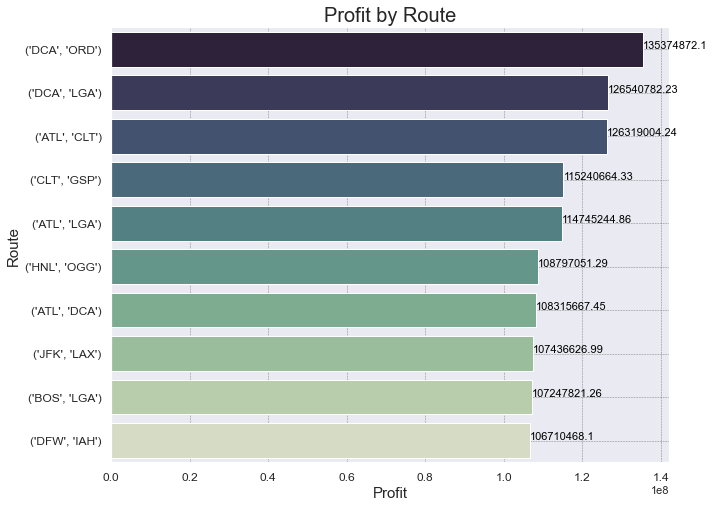

In [93]:
# Set a theme for the plot
sns.set_theme()

# Set the color palette
colors = sns.cubehelix_palette(10, start=.5, rot=-.75, reverse=True)

# Take the top 10 routes
top_routes = grouped.head(10).reset_index()

# Plot the data
plt.figure(figsize=(10, 8))
barplot = sns.barplot(x='PROFIT', y='ROUTE', data=top_routes, palette=colors)
plt.xlabel('Profit', fontsize=15)
plt.ylabel('Route', fontsize=15)
plt.title('Profit by Route', fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add numbers on each bar
for i in barplot.patches:
    barplot.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()), 2)), fontsize=11, color='black')

plt.show()

## Problem 3: Recommended Routes <a name="problem3"></a>
The 5 round trip routes that you recommend to invest in based on any factors that you
choose.

Investing in a route is primarily guided by its total profit; the higher this aggregate profit, the more promising the investment opportunity appears to be.

Yet, total profit alone doesn't provide the full picture. It's equally vital to consider our market penetration rate within that route, even though direct data might not be available. A substantial indicator for market penetration can be inferred from the average OCCUPANCY_RATE of the route. A high occupancy rate indicates a large number of customers with limited plane choices, reflecting a strong penetration rate in the market.

To harmonize both these factors, we'll introduce a new indicator after feature scaling:
#### PROFIT * OCCUPANCY_RATE.



This combined metric captures the complexity of the route's investment potential by aligning the total profitability with market penetration, offering a more refined and informed basis for decision-making.

In [94]:
grouped = df.groupby('ROUTE').agg({
    'OCCUPANCY_RATE': 'mean', 
    'PROFIT': 'sum'
}).reset_index()

In [95]:
# create a MinMaxScaler object
scaler = MinMaxScaler()

# Perform the scaling operation on 'OCCUPANCY_RATE' column

grouped['OCCUPANCY_RATE'] = scaler.fit_transform(grouped[['OCCUPANCY_RATE']])

# We have to fit the scaler again for 'PROFIT' column as the value ranges could be different
grouped['PROFIT'] = scaler.fit_transform(grouped[['PROFIT']])

In [96]:
grouped

,ROUTE,OCCUPANCY_RATE,PROFIT
0,"(ABE, ATL)",0.491622,0.231977
1,"(ABE, CLT)",0.503743,0.244319
2,"(ABE, DTW)",0.475601,0.186794
3,"(ABE, FLL)",0.403664,0.094869
4,"(ABE, ORD)",0.482235,0.181585
...,...,...,...
2823,"(STL, TPA)",0.499055,0.139876
2824,"(STL, TUL)",0.477242,0.152671
2825,"(SYR, TPA)",0.422132,0.093504
2826,"(TPA, TTN)",0.464911,0.082336


In [97]:
# Creating new features 
grouped['OCCUPANCY_PROFIT'] = grouped['OCCUPANCY_RATE'] * grouped['PROFIT']
grouped = grouped.sort_values('OCCUPANCY_PROFIT', ascending=False)

In [98]:
grouped

,ROUTE,OCCUPANCY_RATE,PROFIT,OCCUPANCY_PROFIT
1130,"(DCA, ORD)",0.480134,1.000000,0.480134
1114,"(DCA, LGA)",0.488538,0.940964,0.459696
135,"(ATL, CLT)",0.481843,0.939482,0.452683
189,"(ATL, LGA)",0.485848,0.862138,0.418868
849,"(CLT, GSP)",0.483106,0.865449,0.418103
...,...,...,...,...
2712,"(PSP, SJC)",0.071683,0.095459,0.006843
2585,"(ORD, TWF)",0.071683,0.095367,0.006836
987,"(CRW, PIT)",0.071683,0.095270,0.006829
549,"(BOS, LAX)",0.479096,0.000000,0.000000


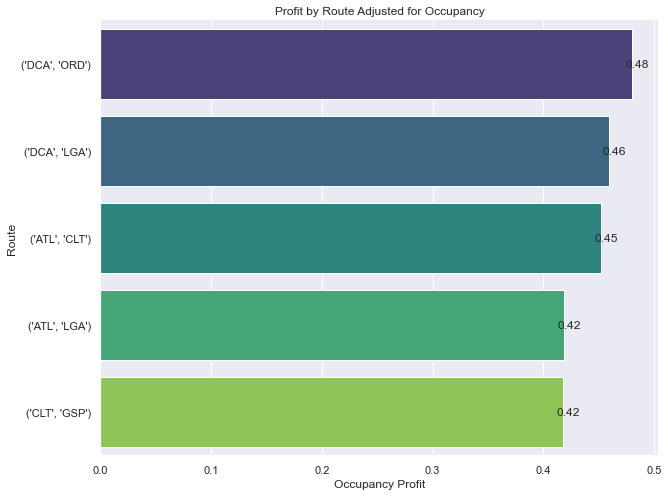

In [99]:
# Take top 10 routes for the plot
top_routes = grouped.sort_values('OCCUPANCY_PROFIT', ascending=False).head(5)

plt.figure(figsize=(10, 8))
barplot = sns.barplot(x='OCCUPANCY_PROFIT', y='ROUTE', data=top_routes, palette='viridis')
plt.xlabel('Occupancy Profit')
plt.ylabel('Route')
plt.title('Profit by Route Adjusted for Occupancy')

# Annotate each bar with the corresponding value
for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.2f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center',
                     xytext=(5, 0),
                     textcoords='offset points')

sns.despine()
plt.show()


## Problem 4: Breakeven Analysis <a name="problem4"></a>
The number of round trip flights it will take to breakeven on the upfront airplane cost for
each of the 5 round trip routes that you recommend. Print key summary components for
these routes.

In [100]:
# Sort by 'OCCUPANCY_PROFIT' and get the top 5 routes
top_routes = grouped.sort_values('OCCUPANCY_PROFIT', ascending=False).head(5)

top_routes

,ROUTE,OCCUPANCY_RATE,PROFIT,OCCUPANCY_PROFIT
1130,"(DCA, ORD)",0.480134,1.000000,0.480134
1114,"(DCA, LGA)",0.488538,0.940964,0.459696
135,"(ATL, CLT)",0.481843,0.939482,0.452683
189,"(ATL, LGA)",0.485848,0.862138,0.418868
849,"(CLT, GSP)",0.483106,0.865449,0.418103


In [101]:
#Sort by 'OCCUPANCY_PROFIT' and get the top 5 routes
top_routes = grouped.sort_values('OCCUPANCY_PROFIT', ascending=False).head(5)

# Get the ROUTE values for the top 5 routes
top_route_names = top_routes['ROUTE'].values

# Filter the original DataFrame to include only these routes
df_top_routes = df[df['ROUTE'].isin(top_route_names)]

# Group by 'ROUTE' and calculate the average 'PROFIT'
average_profits = df_top_routes.groupby('ROUTE').agg({'PROFIT': 'mean'}).reset_index()

# Convert the 'ROUTE' column in 'average_profits' to a categorical variable
# with categories given by the 'ROUTE' values in 'top_route_names' and ordered=True
average_profits['ROUTE'] = pd.Categorical(average_profits['ROUTE'], categories=top_route_names, ordered=True)

# Sort by 'ROUTE' 
average_profits = average_profits.sort_values('ROUTE')

print(average_profits)

        ROUTE        PROFIT
4  (DCA, ORD)  36637.313154
3  (DCA, LGA)  37672.159044
0  (ATL, CLT)  41065.996177
1  (ATL, LGA)  24977.197401
2  (CLT, GSP)  74492.995691


In [102]:
upfront_cost = 90000000  # $90 million

# Let's assume that 'average_profits' DataFrame contains the average profit per plane for each route
average_profits['FLIGHTS_TO_BREAKEVEN'] = upfront_cost / average_profits['PROFIT']

print(average_profits)

        ROUTE        PROFIT  FLIGHTS_TO_BREAKEVEN
4  (DCA, ORD)  36637.313154           2456.512016
3  (DCA, LGA)  37672.159044           2389.032173
0  (ATL, CLT)  41065.996177           2191.594223
1  (ATL, LGA)  24977.197401           3603.286572
2  (CLT, GSP)  74492.995691           1208.167280


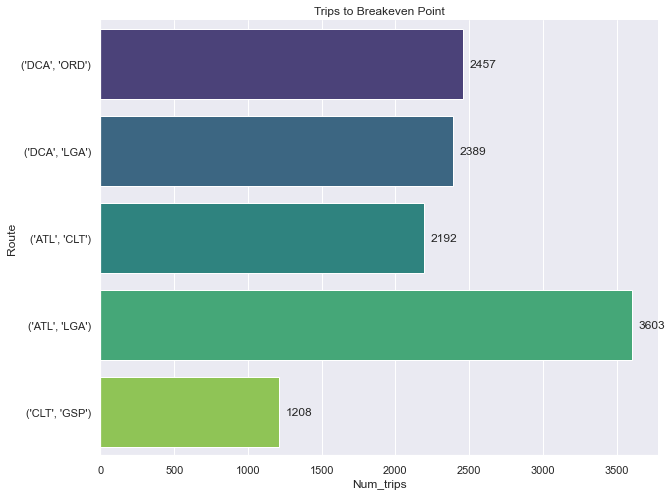

In [103]:
plt.figure(figsize=(10, 8))
barplot = sns.barplot(x='FLIGHTS_TO_BREAKEVEN', y='ROUTE', data=average_profits, palette='viridis')
plt.xlabel('Num_trips')
plt.ylabel('Route')
plt.title('Trips to Breakeven Point')

# Adding the numbers on top of each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2.),
                     ha = 'center',
                     va = 'center',
                     xytext = (20, 0),
                     textcoords = 'offset points')

sns.despine()
plt.show()

In [104]:
average_profits["ROUTE"]

4    (DCA, ORD)
3    (DCA, LGA)
0    (ATL, CLT)
1    (ATL, LGA)
2    (CLT, GSP)
Name: ROUTE, dtype: category
Categories (5, object): [('DCA', 'ORD') < ('DCA', 'LGA') < ('ATL', 'CLT') < ('ATL', 'LGA') < ('CLT', 'GSP')]

In [105]:
top_route = df.merge(average_profits, how="inner", on="ROUTE")

In [106]:
#  Print key summary components for these routes
grouped_data = top_route.groupby('ROUTE').agg(
    PROFIT_PER_TRIP=pd.NamedAgg(column='PROFIT_y', aggfunc='mean'),
    FLIGHTS_TO_BREAKEVEN=pd.NamedAgg(column='FLIGHTS_TO_BREAKEVEN', aggfunc='mean'),
    DISTANCE=pd.NamedAgg(column='DISTANCE', aggfunc='mean'),
    OCCUPANCY_RATE=pd.NamedAgg(column='OCCUPANCY_RATE', aggfunc='mean'),
    AVERAGE_FARE=pd.NamedAgg(column='AVERAGE_FARE', aggfunc='mean')
)

grouped_data

,PROFIT_PER_TRIP,FLIGHTS_TO_BREAKEVEN,DISTANCE,OCCUPANCY_RATE,AVERAGE_FARE
ROUTE,,,,,
"(ATL, CLT)",41065.996177,2191.594223,226.0,0.648875,481.100648
"(ATL, LGA)",24977.197401,3603.286572,762.0,0.651110,440.637995
"(CLT, GSP)",74492.995691,1208.167280,75.0,0.649580,718.333333
"(DCA, LGA)",37672.159044,2389.032173,214.0,0.652611,468.605319
"(DCA, ORD)",36637.313154,2456.512016,612.0,0.647922,515.448590


## Problem 5: Key Performance Indicators <a name="problem5"></a>
Key Performance Indicators (KPI’s) that you recommend tracking in the future to
measure the success of the round trip routes that you recommend.

###### I will track profit part and customer satisfaction (mainly on-time performance) part  

#### Profit:
Occupancy Rate: Monitoring this rate enables the airline to gauge demand for specific routes and optimize scheduling and capacity planning. High occupancy rates often indicate profitable routes, while low rates may suggest a need for adjustments in pricing, marketing, or scheduling.

Tickets Fare: Tracking ticket fares allows the airline to understand its pricing strategy's effectiveness and competitiveness in the market. Adjusting pricing in real-time to respond to demand, competitor pricing, or other market factors can maximize revenue.

Total Flight Count: Understanding this metric enables the airline to identify trends, allocate resources more effectively, and plan for capacity adjustments as needed.

#### Customer Satisfaction (On-Time Performance):
Arrival Delay: Given the airline's reputation, maintaining low arrival delays is crucial. Regular monitoring allows the airline to keep an eye on potential issues and take proactive measures to preserve its reputation for punctuality.

Departure Delay: Likewise, monitoring departure delays helps ensure that the airline maintains the high standard of on-time departures that its customers expect. This contributes to the overall satisfaction and loyalty of the customer base.
 

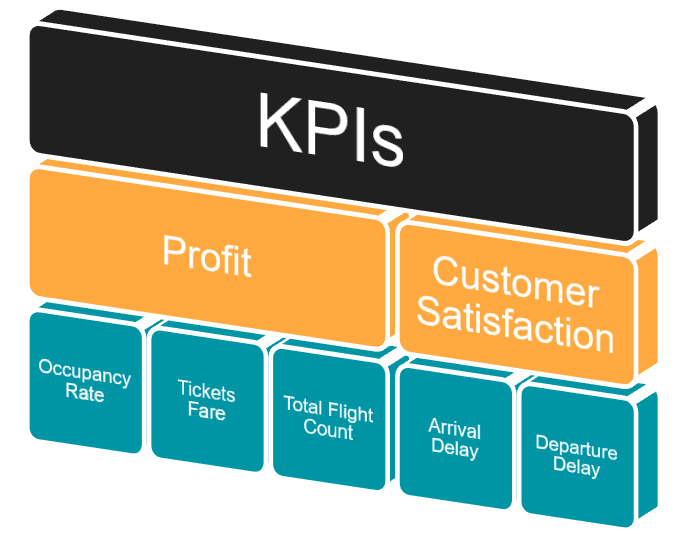

# Further Steps  <a name="nextsteps"></a>

##### Analyze the influence of punctuality on both ticket fare and occupancy rate

##### Identify the routes where customers require more timely airplane arrivals

##### Analyze the relationship between various contributing factors and the overall profit
